# Collaborative Filtering - Matrix Factorization

This script takes user and movie ratings as input to predict a user's rating of another movie, and thus recommend it.

The following code borrows heavily from the following websites

https://blog.fastforwardlabs.com/2018/04/10/pytorch-for-recommenders-101.html

https://www.ethanrosenthal.com/2017/06/20/matrix-factorization-in-pytorch/

https://github.com/groverpr/deep-learning/blob/master/recommendation_engine/netflix_collaborative_filtering.ipynb?fbclid=IwAR0UKO20pkXMQMtkkWjoDIl9De7U2mXyr4NNKoEfc5tkT9drJMTI62-GGt8

https://github.com/fastai/fastai/blob/master/courses/dl1/lesson5-movielens.ipynb?fbclid=IwAR3P7o6Dgx1aaG7aATYhxYU0VYUNFM3iVKj2L33K5pGl48DTrQGaF5AiKkg


In [1]:
#!pip install torchtext
#!pip install torch

In [2]:
#### Packages ####
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [3]:
#### Loading dataset ####
# We are only interested in user ID, movie ID and ratings
ratings_df = pd.read_csv('ratings_small.csv', usecols = ['userId','movieId','rating'])

In [4]:
#### Creating new indices ####
def zero_indexing(column):
    uniq = column.unique()
    newindex = {o:i for i,o in enumerate(uniq)}
    # Subtracting 1 from the original ID's
    return newindex, np.array([newindex.get(x, -1) for x in column])

_,usercol = zero_indexing(ratings_df["userId"])
_,moviecol = zero_indexing(ratings_df["movieId"])

ratings_df["userId"] = usercol
ratings_df["movieId"] = moviecol

# Removing ID's which are less than 0
ratings_dataset = ratings_df[ratings_df["userId"] >= 0]
ratings_dataset = ratings_df[ratings_df["movieId"] >= 0]

print("Printing head of dataset with new IDs: ")
ratings_dataset.head()

Printing head of dataset with new IDs: 


,userId,movieId,rating
0,0,0,2.5
1,0,1,3.0
2,0,2,3.0
3,0,3,2.0
4,0,4,4.0


In [5]:
#### Splitting dataset into training, validation and test sets ####
n = len(ratings_dataset)
sizes = [0.7, 0.2, 0.1]
train_size = int(sizes[0]*n)
val_size = int(sizes[1]*n)
test_size = int(sizes[2]*n)

train_set = ratings_dataset[:train_size-1].copy() # till 70002-1 = 70001
val_set = ratings_dataset[train_size:-test_size-1].copy() # from 70002 to 100.004 - 20000
test_set = ratings_dataset[train_size+val_size:].copy() # from train+val size

print("Entire dataset: ", n)
print("Train size: ", train_set.shape[0])
print("Validation size: ", val_set.shape[0])
print("Test size: ", test_set.shape[0])
print("Checking if dimensions match: ", train_set.shape[0] + val_set.shape[0] + test_set.shape[0] == n )

Entire dataset:  100004
Train size:  70001
Validation size:  20001
Test size:  10002
Checking if dimensions match:  True


In [6]:
#### Creating a dataformatting to format the data ####
class dataformatting(Dataset):
    def __init__(self, users, movies, rating):
        self.movies = movies
        self.users = users
        self.rating = rating
        
    def __len__(self):
        return len(self.rating)

    def __getitem__(self, index):
        u = self.users[index]
        m = self.movies[index]
        r = self.rating[index]
        return [u, m, r]

In [7]:
#### Formatting training, validation and training sets ####
u_train = torch.LongTensor(train_set.userId.values)
m_train = torch.LongTensor(train_set.movieId.values)
r_train = torch.FloatTensor(train_set.rating.values)

train_dataset = dataformatting(u_train, m_train, r_train)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

u_val = torch.LongTensor(val_set.userId.values)
m_val = torch.LongTensor(val_set.movieId.values)
r_val = torch.FloatTensor(val_set.rating.values)
val_dataset = dataformatting(u_val, m_val,r_val)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=True)

u_test = torch.LongTensor(test_set.userId.values)
m_test = torch.LongTensor(test_set.movieId.values)
r_test = torch.FloatTensor(test_set.rating.values)
test_dataset = dataformatting(u_test, m_test, r_test)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True)

In [8]:
num_user = len(ratings_dataset.userId.unique()) 
num_movie = len(ratings_dataset.movieId.unique())
emb_size = 10

class MatrixFactorization(nn.Module):
    def __init__(self, num_user, num_movie):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(num_user, emb_size)
        self.movie_embedding = nn.Embedding(num_movie, emb_size)
        
    def forward(self, u, m):
        U = self.user_embedding(u)
        M = self.movie_embedding(m)
        r_max = 5 # maximum rating
        r_min = 1 # minimum rating
        res = torch.sigmoid((U*M).sum(1))*(r_max - r_min) + r_min
        return res

In [9]:
## Training loop
def training(MF, train_iter, optimizer, criterion, epoch):
    MF.train()
    trainloss = 0
    
    for batch_idx, data in enumerate(train_iter):
        
        users, items, ratings = data
        batch_size = len(users)
        users = users.long()
        items = items.long()
        ratings = ratings.float()      
        ratings = ratings.view(-1)
        optimizer.zero_grad()
        out = MF(users, items)
        out = out.view(-1)
        loss = criterion(out.float(), ratings)
        loss.backward()
        optimizer.step()
        
        trainloss += loss.item()
        
    return trainloss/len(train_iter)

def validate(MF, val_iter, criterion, epoch):
    MF.eval()
    valloss = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(val_iter):
            users, items, ratings = data
            batch_size = len(users)
            users = users.long()
            items = items.long()
            ratings = ratings.float()
            ratings = ratings.view(-1)
            out = MF(users, items)
            loss = criterion(out.float(), ratings)
            valloss+=loss.item()

    return valloss/len(val_iter)

def trainLoop(epochs, lr=0.001, wd = 1e-6):
    # Defining model    
    MF = MatrixFactorization(num_user, num_movie)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, MF.parameters()), lr=lr, weight_decay = wd)
    
    lossestrain = []
    lossesval = []
    
    for epoch in range(1, epochs + 1):
        trainloss = training(MF, train_iter, optimizer, criterion, epoch)
        valloss = validate(MF, val_iter, criterion, epoch)
        
        lossestrain += [trainloss]
        lossesval += [valloss]
        print(f'Epoch {epoch}: Training loss: {trainloss:2.5f} | Validation loss: {valloss:2.5f}')

    #### Plots ####
    plt.plot(range(1,epoch+1),lossestrain)
    plt.plot(range(1,epoch+1),lossesval)
    plt.xlabel('Epochs'), plt.ylabel('Loss')
    plt.legend(['Training loss','Validation loss'], loc = 1)
    plt.show()

Epoch 1: Training loss: 3.42099 | Validation loss: 2.52351
Epoch 2: Training loss: 3.19348 | Validation loss: 1.90251
Epoch 3: Training loss: 2.95929 | Validation loss: 1.60029
Epoch 4: Training loss: 2.73218 | Validation loss: 1.49691
Epoch 5: Training loss: 2.52018 | Validation loss: 1.44183
Epoch 6: Training loss: 2.32462 | Validation loss: 1.44350
Epoch 7: Training loss: 2.14679 | Validation loss: 1.41909
Epoch 8: Training loss: 1.99480 | Validation loss: 1.43833
Epoch 9: Training loss: 1.86719 | Validation loss: 1.42348
Epoch 10: Training loss: 1.75509 | Validation loss: 1.43818
Epoch 11: Training loss: 1.66155 | Validation loss: 1.41834
Epoch 12: Training loss: 1.57258 | Validation loss: 1.42313
Epoch 13: Training loss: 1.49260 | Validation loss: 1.42299
Epoch 14: Training loss: 1.42644 | Validation loss: 1.41789
Epoch 15: Training loss: 1.35863 | Validation loss: 1.42261
Epoch 16: Training loss: 1.29345 | Validation loss: 1.42854
Epoch 17: Training loss: 1.22458 | Validation los

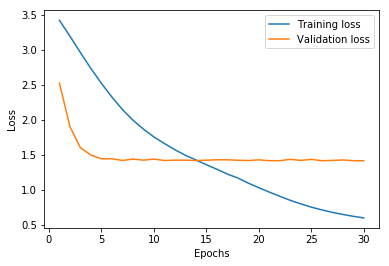

In [10]:
#### All Systems Go! ####
trainLoop(epochs = 30, lr = 0.001, wd = 1e-5)